<a href="https://colab.research.google.com/github/ronalds82/Datu-kopas-tulkosana/blob/main/SQuAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autors: *Ronalds Turnis, rt20018*
===========================


# Globālie mainīgie

In [1]:
INSTALL = False # True, ja videi ir nepieciešamas papildus instalācijas
TRAIN = False  # True, ja modelim ir nepieciešama satura regulēšana
FINE_TUNED = False # True, ja testējam pašu saglabātu modeli
CHAT = False # True, ja vēlamies ieslēgt tērzētavu ar modeli
FLATTEN = True # True, ja ir nepieciešama SQuAD datu kopas "saspiešana" (ja faili neeksistē)

weights_dir = './weights' # Tiek glabāti modeļa svari
logs_dir = './logs' # Tiek glabāta notikumu informācija
tmp_dir = './tmp_trainer' # Glabājās pagaidu informācija

# Jānorāda, ja vēlamies veikt pašu saglabāta modeļa novērtēšanu
model_link = 'https://www.dropbox.com/scl/fi/cguiqykr0jlp1yj6mi7rm/modelis.pth?rlkey=m7oeyaev1pt0x1c5u2kdnl0bu&dl=0'
model_weight_file = 'modelis.pth?rlkey=m7oeyaev1pt0x1c5u2kdnl0bu'

# 1.1 vai 2.0
SQuAD_version = '2.0'

# SQUAD testēšanai nepieciešamie mainīgie
data_files = {'train': f'train-v{SQuAD_version}.json', 'validation': f'train-v{SQuAD_version}.LV.json'}
flattened_train_file_1 = 'flattened_train_file_1.json'
flattened_val_file_2 = 'flattened_val_file_2.json'

# Šie ir nepieciešami failu saglabāšanai, bet netiek izmantoti
flattened_val_file_1 = 'flattened_val_file_1.json'
flattened_train_file_2 = 'flattened_train_file_2.json'

# Faili, kuri tiks izmantoti apmācības un validācijas laikā
flattened_data_files = {'train': flattened_train_file_1, 'validation': flattened_val_file_2}

test_size = 0.2 # LV validācijas datu kopas izmērs attiecībā pret apmācības datu kopu

model_name = 'bert-base-multilingual-cased' # Norādām HuggingFace modeli, kurš tiks izmantots

max_length = 384 # Maksimālais garums context un question string tipa mainīgajiem
doc_stride = 128 # Pārlaidums starp segmentiem, lai apstrādātu garākus tekstus, nekā modelis var apstrādāt vienlaikus

# Moduļu importēšana

In [2]:
# Ja ir nepieciešamas papildus instalācijas
if INSTALL:
    !pip install datasets
    !pip install transformers[torch] -U
    !pip install accelerate -U
    !pip install rouge_score
    !pip install evaluate

# Importējam nepieciešamos moduļus
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import evaluate
import json
import collections
from tqdm import tqdm, tqdm_notebook
from transformers import Trainer, TrainingArguments, IntervalStrategy, DataCollatorForLanguageModeling, trainer_utils, EvalPrediction
from transformers import default_data_collator, AutoTokenizer, AutoModelForQuestionAnswering, tokenization_utils_base
from sklearn.model_selection import train_test_split
from google.colab import files
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
from datasets import load_dataset, arrow_dataset
from torch.nn import CrossEntropyLoss
from pathlib import Path
from typing import Optional, Tuple

# Modeļa un tokenizera inicializācija

In [3]:
print("Ielādējam modeli un tokenizeru...")

# Modeļa un tokenizera definēšana
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Iestatām padding tokenu, ja tā nav
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Pārbaudām CUDA pieejamību un uzstādām modeli uz atbilstošās ierīces
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Modelis un tokenizeris inicializēts!")
print("Izmantotā ierīce:", device)

Ielādējam modeli un tokenizeru...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelis un tokenizeris inicializēts!
Izmantotā ierīce: cuda


# Iepriekšējo datu dzēšana

In [4]:
# Pārbaudām vai eksistē ģenerētās direktorijas un dzēšam tās pirms modeļa trenēšanas, lai nekonfliktētu ar vecajiem datiem
def delete_directory(dir_path):
    try:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
            print(f"Direktorija dzēsta: {dir_path}")
        else:
            print(f"Direktorija neeksistē: {dir_path}")
    except Exception as e:
        print(f"Kļūda dzēšot direktoriju: {e}")

delete_directory(weights_dir)
delete_directory(logs_dir)
delete_directory(tmp_dir)

# Izdzēšam GPU kešatmiņu
torch.cuda.empty_cache()

Direktorija dzēsta: ./weights
Direktorija neeksistē: ./logs
Direktorija neeksistē: ./tmp_trainer


# Datu inicializācija

In [5]:
# Pārbaudam, vai "spilventiņš" ir uz labās puses
pad_on_right = tokenizer.padding_side == "right"

# SquadDatasetFlat klase ar norādītajiem failiem un ceļiem
class SquadDatasetFlat():
    def __init__(self,
                 path_to_json_file: str,
                 checkpoint_path: str,
                 train_file: str,
                 val_file: str) -> None:
        self.path_to_json_file = path_to_json_file
        self.checkpoint_path = checkpoint_path

        self.train_file = train_file
        self.val_file = val_file

        self.data = self.load_data()

    def load_data(self):
        # Atver un nolasa JSON failu ar apmācības datiem
        with open(self.path_to_json_file, 'r') as f:
            train_data = json.load(f)
        print(f'Flattening SQUAD {train_data["version"]}')

        # Izlīdzina SQUAD datus apmācībai un validācijai
        train_data_flat, val_data_flat, errors = self.load_squad_data(train_data)
        print(f'\nErroneous Datapoints: {errors}')

        # Saglabā izlīdzinātos apmācības datus
        with open(Path(self.checkpoint_path) / Path(self.train_file), 'w') as file:
            train_data = {'data': train_data_flat}
            file.write(json.dumps(train_data))
            file.close()

        # Saglabā izlīdzinātos validācijas datus
        with open(Path(self.checkpoint_path) / Path(self.val_file), 'w') as file:
            val_data = {'data': val_data_flat}
            file.write(json.dumps(val_data))
            file.close()

    def load_squad_data(self, data):
        # Inicializē kļūdu skaitu un tukšus sarakstus izlīdzinātiem datiem
        errors = 0
        flattened_data_train = []
        flattened_data_val = []

        # Aprēķina robežu, līdz kurai dati tiks izmantoti apmācībai
        train_range = len(data['data']) - (len(data['data']) * test_size)

        # Pāriet cauri visiem datiem un izlīdzina tos
        for i, article in enumerate(data["data"]):
            title = article.get("title", "").strip()
            for paragraph in article["paragraphs"]:
                context = paragraph["context"].strip()
                for qa in paragraph["qas"]:
                    question = qa["question"].strip()
                    id_ = qa["id"]

                    # Iegūst atbildes sākuma pozīcijas un pašas atbildes
                    answer_starts = [answer["answer_start"] for answer in qa["answers"]]
                    answers = [answer["text"].strip() for answer in qa["answers"]]

                    # Pievieno datus apmācībai vai validācijai atkarībā no indeksa
                    if i <= train_range:
                        flattened_data_train.append({"title": title,
                                                     "context": context,
                                                     "question": question,
                                                     "id": id_,
                                                     "answers": {
                                                         "answer_start": answer_starts,
                                                         "text": answers}
                                                     })
                    else:
                        flattened_data_val.append({"title": title,
                                                   "context": context,
                                                   "question": question,
                                                   "id": id_,
                                                   "answers": {
                                                       "answer_start": answer_starts,
                                                       "text": answers}
                                                   })

        # Atgriež izlīdzinātos apmācības un validācijas datus kopā ar kļūdu skaitu
        return flattened_data_train, flattened_data_val, errors

def prepare_squad_dataset(examples: collections.OrderedDict or dict) -> tokenization_utils_base.BatchEncoding:
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Tā kā viens piemērs var mums dot vairākus paraugus, ja tajā ir garš konteksts, mums ir vajadzīga karte no parauga uz
    # tā atbilstošo piemēru. Šī atslēga mums to dod
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # Offsetu kartējumi mums dos karti no tokena uz rakstzīmes pozīciju sākotnējā kontekstā. Tas
    # palīdzēs mums aprēķināt starta pozīcijas un beigu pozīcijas
    offset_mapping = tokenized_examples.pop("offset_mapping")
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # CLS indeksa iegūšana
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Paņemam sekvenci, kas atbilst šim piemēram (lai zinātu, kas ir konteksts un kas ir jautājums)
        sequence_ids = tokenized_examples.sequence_ids(i)

        # Viens piemērs var dot vairākus spanus, šis ir indekss piemēram, kas satur šo tekstu
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Atbilžu sākuma/beigu rakstzīmju indeksi tekstā
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Sākuma tokena indekss pašreizējam spanam tekstā
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # Beigu tokena indekss pašreizējam spanam tekstā
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Pārbaudām, vai atbilde ir ārpus spana (šajā gadījumā šis paraugs tiek marķēts ar CLS indeksu)
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Pārvietojam token_start_index un token_end_index uz atbildes abiem galiem
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

def prepare_validation_features(examples: collections.OrderedDict or dict) -> tokenization_utils_base.BatchEncoding:
    # Tokenizējam mūsu piemērus ar trancēšanu un varbūt arī ar spilventiņu, bet paturam pārplūdes, izmantojot stride. Tas rezultējas
    # vienā piemēra iespējā dot vairākus paraugus, ja konteksts ir garš, katram no šiem paraugiem ir
    # konteksts, kas pārklājas mazliet ar iepriekšējā parauga kontekstu
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Tā kā viens piemērs var mums dot vairākus paraugus, ja tajā ir garš konteksts, mums ir vajadzīga karte no parauga uz
    # tā atbilstošo piemēru. Šī atslēga mums to dod
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # Offsetu kartējumi mums dos karti no tokena uz rakstzīmes pozīciju sākotnējā kontekstā. Tas
    # palīdzēs mums aprēķināt starta_pozīcijas un beigu_pozīcijas
    offset_mapping = tokenized_examples["offset_mapping"]
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # CLS indekss
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Iegūstam secību, kas atbilst šim piemēram (lai zinātu, kas ir konteksts un kas ir jautājums)
        sequence_ids = tokenized_examples.sequence_ids(i)

        # Viens piemērs var dot vairākus posmus, šis ir piemēra indekss, kas satur šo teksta posmu
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Atbilžu sākuma/beigu rakstzīmju indeksi tekstā
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Sākuma tokena indekss pašreizējā teksta posmā
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # Beigu tokena indekss pašreizējā teksta posmā
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Nosaka, vai atbilde ir ārpus posma (šajā gadījumā šī iezīme tiek marķēta ar CLS indeksu)
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Pretējā gadījumā pārvieto token_start_index un token_end_index uz abiem atbildes galiem
                # Piezīme: mēs varētu pāriet aiz pēdējā ofseta, ja atbilde ir pēdējais vārds (izņēmuma gadījums)
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    # Mēs saglabājam example_id, kas mums deva šo iezīmi, un mēs saglabāsim ofsetu kartējumus
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Iegūstam secību, kas atbilst šim piemēram (lai zinātu, kas ir konteksts un kas ir jautājums)
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # Viens piemērs var dot vairākus posmus, šis ir piemēra indekss, kas satur šo teksta posmu
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Nosaka par None ofsetu kartējumus, kas nav daļa no konteksta, lai būtu viegli noteikt, vai tokena
        # pozīcija ir daļa no konteksta vai nē
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

# Sagatavojam datus
if FLATTEN:
    _ = SquadDatasetFlat(data_files['train'], '', flattened_train_file_1, flattened_val_file_1)
    _ = SquadDatasetFlat(data_files['validation'], '', flattened_train_file_2, flattened_val_file_2)

train_data = load_dataset("json", data_files=flattened_data_files['train'], field='data')
val_data = load_dataset("json", data_files=flattened_data_files['validation'], field='data')

train_dataset = train_data.map(prepare_squad_dataset, batched=True, remove_columns=train_data['train'].column_names)
val_dataset = val_data['train'].map(prepare_validation_features, batched=True, remove_columns=val_data['train'].column_names)

Flattening SQUAD v2.0

Erroneous Datapoints: 0
Flattening SQUAD v2.0

Erroneous Datapoints: 0


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/103520 [00:00<?, ? examples/s]

Map:   0%|          | 0/25274 [00:00<?, ? examples/s]

In [6]:
print(train_dataset['train'][:5])

{'input_ids': [[101, 12242, 12172, 40344, 104316, 15148, 19881, 12600, 136, 102, 54106, 144, 68085, 69382, 118, 18047, 113, 120, 100, 120, 10347, 10112, 118, 162, 30118, 118, 23763, 114, 113, 11175, 10596, 125, 117, 10654, 114, 10124, 10151, 10536, 17956, 117, 36780, 117, 12410, 16607, 10111, 24268, 119, 18021, 10111, 20526, 10106, 18551, 117, 12466, 117, 10833, 15282, 10106, 13547, 34746, 10111, 69463, 44575, 10146, 169, 18048, 117, 10111, 29467, 10114, 51930, 10106, 10105, 13002, 22829, 10146, 14107, 17956, 10108, 155, 111, 139, 24699, 118, 11795, 47933, 112, 187, 21640, 119, 109645, 18832, 10155, 10485, 13194, 117, 51322, 26127, 69382, 117, 10105, 11795, 11179, 10464, 10108, 10105, 11356, 112, 187, 12504, 118, 30870, 24699, 15647, 10108, 10435, 10635, 119, 17551, 11520, 26311, 17112, 10105, 14072, 10108, 54106, 112, 187, 13424, 10606, 117, 51472, 10454, 10106, 11248, 113, 10295, 114, 117, 10319, 13245, 10485, 10146, 169, 11395, 16410, 31197, 117, 21293, 12403, 20959, 12357, 10111, 1

# SQuAD datu kopas analīze

In [7]:
def get_text(answer: list) -> str:
  if len(answer) == 0:
      return ''
  else:
      return answer[0]

def get_json_data(json_path: str) -> dict:
    f = open(json_path)

    # Atgriež JSON objektu kā sarakstu
    json_data = json.load(f)

    f.close()
    return json_data

train_dataframe = pd.json_normalize(get_json_data(flattened_train_file_1), record_path='data')
train_dataframe["answers.text"] = train_dataframe["answers.text"].apply(get_text)

train_dataframe

,title,context,question,id,answers.answer_start,answers.text
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,56be85543aeaaa14008c9063,[269],in the late 1990s
1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,56be85543aeaaa14008c9065,[207],singing and dancing
2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,56be85543aeaaa14008c9066,[526],2003
3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,56bf6b0f3aeaaa14008c9601,[166],"Houston, Texas"
4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,56bf6b0f3aeaaa14008c9602,[276],late 1990s
...,...,...,...,...,...,...
103515,Neptune,"After the Voyager 2 flyby mission, the next st...",When is the next set-in-stone mission to Neptune?,5acee64f32bba1001ae4b8ff,[],
103516,Neptune,"After the Voyager 2 flyby mission, the next st...",What about Uranus did NASA propose in 2003 in ...,5acee64f32bba1001ae4b900,[],
103517,Neptune,"After the Voyager 2 flyby mission, the next st...",What will launch in 2027?,5acee64f32bba1001ae4b901,[],
103518,Neptune,"After the Voyager 2 flyby mission, the next st...",What will Larrgo visit?,5acee64f32bba1001ae4b902,[],


<Axes: title={'center': 'Konteksta garuma histogramma'}, ylabel='Frequency'>

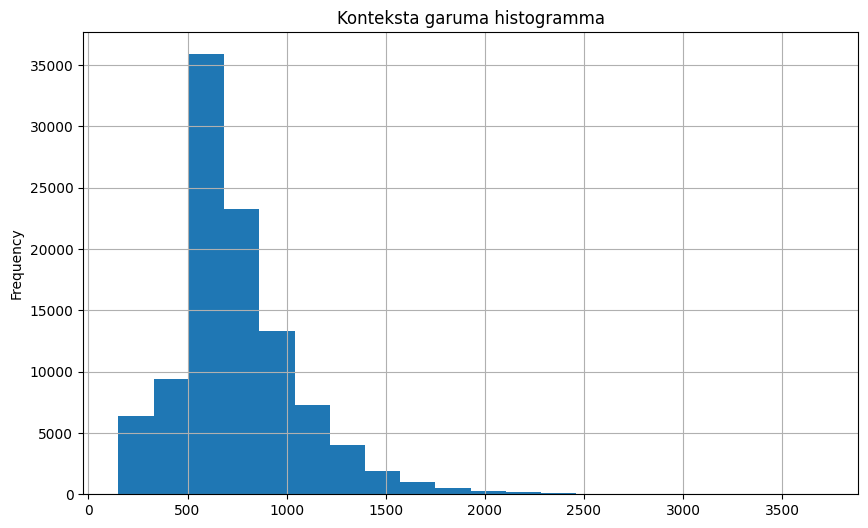

In [8]:
figsize = (10,6)
train_dataframe['context'].apply(len).plot.hist(title="Konteksta garuma histogramma", bins=20, figsize=figsize, grid=True)

<Axes: title={'center': 'Jautājumu garuma histogramma'}, ylabel='Frequency'>

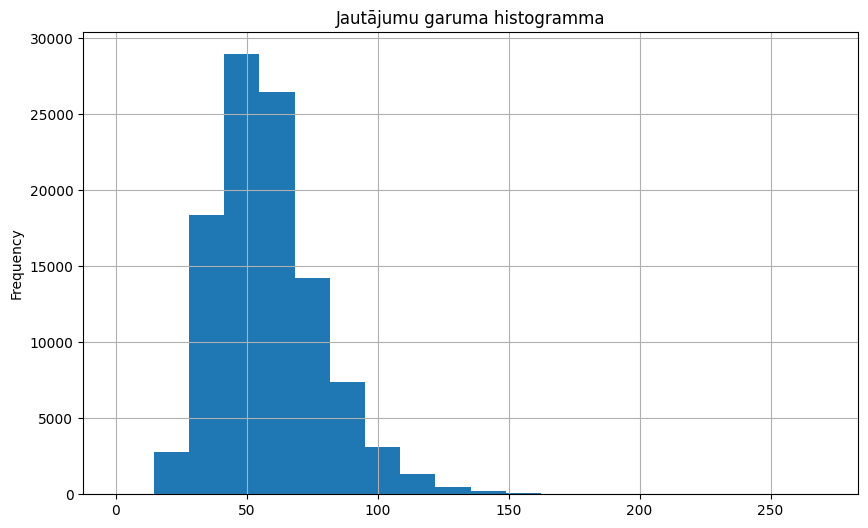

In [9]:
train_dataframe['question'].apply(len).plot.hist(title="Jautājumu garuma histogramma", bins=20, figsize=figsize, grid=True)

# Metriku aprēķināšanas funkcijas

In [10]:
metrics_history = []

metric = evaluate.load("squad_v2" if SQuAD_version == '2.0' else "squad")

def postprocess_qa_predictions(examples: arrow_dataset.Dataset,
                               features: arrow_dataset.Dataset,
                               raw_predictions: tuple,
                               n_best_size: int = 20,
                               max_answer_length: int = 50) -> collections.OrderedDict:
    all_start_logits, all_end_logits = raw_predictions

    # Izveido karti no piemēra ar tā atbilstošajiem featuriem
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)

    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    all_predictions = collections.OrderedDict()
    all_nbest_json = collections.OrderedDict()

    if SQuAD_version == '2.0':
        scores_diff_json = collections.OrderedDict()

    # Iterējam cauri visiem piemēriem
    for example_index, example in enumerate(tqdm(examples)):
        # Indeksi featuriem, kas saistīti ar pašreizējo piemēru
        feature_indices = features_per_example[example_index]

        min_null_prediction = None
        prelim_predictions = []

        # Iterējam caur visiem featuriem, kas saistīti ar pašreizējo piemēru
        for feature_index in feature_indices:
            # Prognozes featuram
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # Kartējam dažas pozīcijas mūsu logitos uz tekstu fragmentiem oriģinālajā kontekstā
            offset_mapping = features[feature_index]["offset_mapping"]
            # Pēc izvēles `token_is_max_context`, ja ir sniegts, mēs izņemam atbildes, kurām nav maksimālā konteksta
            token_is_max_context = features[feature_index].get("token_is_max_context", None)

            # Atjaunināt minimālo nulles prognozi
            feature_null_score = start_logits[0] + end_logits[0]
            if min_null_prediction is None or min_null_prediction["score"] > feature_null_score:
                min_null_prediction = {
                    "offsets": (0, 0),
                    "score": feature_null_score,
                    "start_logit": start_logits[0],
                    "end_logit": end_logits[0],
                }

            # Izskatām visus iespējamos `n_best_size` lielākos sākuma un beigu logitus
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Neņem vērā atbildes, kas ir ārpus robežām, vai arī atbilst daļai no input_ids, kas nav kontekstā
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or len(offset_mapping[start_index]) < 2
                        or offset_mapping[end_index] is None
                        or len(offset_mapping[end_index]) < 2
                    ):
                        continue
                    # Neņem vērā atbildes, kuru garums ir vai nu < 0 vai > max_answer_length
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue
                    # Neņem vērā atbildes, kurām nav pieejams maksimālais konteksts (ja šāda informācija ir sniegta)
                    if token_is_max_context is not None and not token_is_max_context.get(str(start_index), False):
                        continue

                    prelim_predictions.append(
                        {
                            "offsets": (offset_mapping[start_index][0], offset_mapping[end_index][1]),
                            "score": start_logits[start_index] + end_logits[end_index],
                            "start_logit": start_logits[start_index],
                            "end_logit": end_logits[end_index],
                        }
                    )
        if SQuAD_version == '2.0' and min_null_prediction is not None:
            # Pievieno minimālo nulles prognozi
            prelim_predictions.append(min_null_prediction)
            null_score = min_null_prediction["score"]

        # Saglabā tikai labākās `n_best_size` prognozes
        predictions = sorted(prelim_predictions, key=lambda x: x["score"], reverse=True)[:n_best_size]

        # Pievieno atpakaļ minimālo nulles prognozi, ja tā tika izņemta zemas punktu skaita dēļ
        if (
            SQuAD_version == '2.0'
            and min_null_prediction is not None
            and not any(p["offsets"] == (0, 0) for p in predictions)
        ):
            predictions.append(min_null_prediction)

        # Izmanto nobīdes, lai iegūtu atbildes tekstu oriģinālajā kontekstā
        context = example["context"]
        for pred in predictions:
            offsets = pred.pop("offsets")
            pred["text"] = context[offsets[0] : offsets[1]]

        # Ļoti retos gadījumos, kad nav nevienas nenulles prognozes, mēs izveidojam viltus prognozi, lai izvairītos no kļūdas
        if len(predictions) == 0 or (len(predictions) == 1 and predictions[0]["text"] == ""):
            predictions.insert(0, {"text": "empty", "start_logit": 0.0, "end_logit": 0.0, "score": 0.0})

        # Aprēķina visu punktu skaitu softmax
        scores = np.array([pred.pop("score") for pred in predictions])
        exp_scores = np.exp(scores - np.max(scores))
        probs = exp_scores / exp_scores.sum()

        # Iekļauj varbūtības mūsu prognozēs
        for prob, pred in zip(probs, predictions):
            pred["probability"] = prob

        # Izvēlas labāko prognozi
        if not SQuAD_version == '2.0':
            all_predictions[example["id"]] = predictions[0]["text"]
        else:
            # Pretējā gadījumā vispirms mums ir jāatrod labākā nenulles prognoze
            i = 0
            while predictions[i]["text"] == "":
                i += 1
            best_non_null_pred = predictions[i]

            # Tad mēs salīdzinām ar nulles prognozi, izmantojot slieksni
            score_diff = null_score - best_non_null_pred["start_logit"] - best_non_null_pred["end_logit"]
            scores_diff_json[example["id"]] = float(score_diff)  # Lai būtu JSON-serializējams
            if score_diff > 0.2:
                all_predictions[example["id"]] = ""
            else:
                all_predictions[example["id"]] = best_non_null_pred["text"]

        # Padara `predictions` JSON-serializējamas, pārvēršot np.float atpakaļ uz float
        all_nbest_json[example["id"]] = [
            {k: (float(v) if isinstance(v, (np.float16, np.float32, np.float64)) else v) for k, v in pred.items()}
            for pred in predictions
        ]

    return all_predictions

def compute_metrics(pred: trainer_utils.EvalPrediction) -> dict:
    # Lai iegūtu galīgās prognozes, mēs varam pielietot mūsu pēcapstrādes funkciju mūsu sākotnējām prognozēm
    final_predictions = postprocess_qa_predictions(val_data['train'], val_dataset, pred.predictions)

    if SQuAD_version == '2.0':
        formatted_predictions = [{"id": str(k), "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
    else:
        formatted_predictions = [{"id": str(k), "prediction_text": v} for k, v in final_predictions.items()]

    # Mums tikai jānomaina prognozes un marķējumi, jo metrika sagaida saraksta sarakstu, nevis vienu lielu sarakstu
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in val_data["train"]]

    # Aprēķinām rezultātu
    results = metric.compute(predictions=formatted_predictions, references=references)

    results_squad = {
        'f1': results['f1'],
        'exact': results['exact']
    }

    metrics_history.append(results_squad)

    return results_squad

# Modeļa trenēšana

In [11]:
training_args = TrainingArguments(
    output_dir=weights_dir,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy=IntervalStrategy.STEPS,
    eval_steps=2500,
    warmup_steps=1000,
    weight_decay=0.001,
    learning_rate=5e-5,
    logging_dir=logs_dir,
    logging_steps=2500,
    save_strategy=IntervalStrategy.EPOCH,
    report_to="none",
    fp16=True,
    label_names=["start_positions", "end_positions"]
)

# Inicializējam traineri
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset['train'],
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator
)

if TRAIN:
    trainer.train()

# Apmācītā modeļa analīze

In [12]:
def plot_results(training_history):
    # Definējam sarakstus uzskaitei
    steps = []
    training_losses = []
    validation_losses = []

    # Ejam cauri katram ierakstam vēsturē
    for entry in training_history:
        if 'loss' in entry:  # Apmācības zaudējums
            steps.append(entry.get('step', len(steps) + 1))
            training_losses.append(entry['loss'])

        if 'eval_loss' in entry:  # Validācijas zaudējums
            validation_losses.append(entry['eval_loss'])

    # Izveidojam grafiku
    plt.figure(figsize=(12, 6))

    if training_losses:
        plt.plot(steps[:len(training_losses)], training_losses, label='Apmācības zaudējums', marker='o')

    if validation_losses:
        validation_steps = steps[:len(validation_losses)]
        plt.plot(validation_steps, validation_losses, label='Validācijas zaudējums', marker='x', linestyle='--')

    plt.xlabel('Soļu skaits')
    plt.ylabel('Zaudējums')
    plt.title('Apmācības un validācijas zaudējums apmācības laikā')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_metrics_history(metrics_history):
    epochs = list(range(1, len(metrics_history)+1))
    plt.figure(figsize=(12, 8))

    # Sagatavojam datus parādīšanai grafikā
    exact_match_scores = [x['exact'] for x in metrics_history]
    f1_scores = [x['f1'] for x in metrics_history]

    # Izveidojam grafiku
    plt.plot(epochs, exact_match_scores, label='Exact Match', marker='o')
    plt.plot(epochs, f1_scores, label='F1', marker='o')

    plt.xlabel('Validācijas solis')
    plt.ylabel('Rezultāts')
    plt.title('Vērtēšanas metriku rezultāti atkarībā no validācijas soļa')
    plt.legend()
    plt.grid(True)
    plt.show()

# Izpildām tikai, ja ir notikusi modeļa pielāgošana, citādi tas tiks darīts "Neapmācīta modeļa analīze" sadaļā
if TRAIN:
    plot_results(trainer.state.log_history)
    print()
    plot_metrics_history(metrics_history)

# Apmācītā modeļa saglabāšana

In [13]:
if TRAIN:
    model_weights = f'{model_name}-modelis.pth'
    torch.save(model.state_dict(), model_weights)

# Neapmācīta modeļa analīze



In [14]:
if FINE_TUNED:
    !wget model_link

    # Ielādējam saglabātos svarus
    model.load_state_dict(torch.load(model_weight_file))

    # Pārbaudām CUDA pieejamību un uzstādām modeli uz atbilstošās ierīces
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    trainer.evaluate(val_dataset)
    print(f'Results: {metrics_history}')

if TRAIN == False:
    trainer.evaluate(val_dataset)
    print(f'Results: {metrics_history}')

100%|██████████| 25274/25274 [01:04<00:00, 394.66it/s]


Results: [{'f1': 2.5815017091303565, 'exact': 0.051436258605681726}]
